# Import Libraries

Necessary libraries for data manipulation, visualization, and handling ECG signals.

`wfdb` and `wfdb.processing`: For reading and handling ECG Signals and annotations from the WaveForm DataBase (WFDB)

In [161]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# WaveForm DataBase package
import wfdb
from wfdb import processing

# Loading and Preparing Data

A single ECG record and its annotations are loaded for detailed exploration.

`record_number` can be adjusted to specify different records.

In [164]:
# Record Number to Read
record_number = 100

# Reads the ECG signal from the selected record
record = wfdb.rdrecord(f"../Data/mitbih_data/{record_number}")

# Reads the annotation for the selected record
annotation = wfdb.rdann(f"../Data/mitbih_data/{record_number}", "atr")

# Exploratory Data Analysis (EDA) on a Single Record

## Exploring the Structure of ECG Signal Data
In this section, we start with basic information about the signal, including sampling rate and signal shape.
To understand the nature and dimensionality of the data before visualization and analysis.

In [167]:
# Display record information
print(f"Signal Name(s): {record.sig_name}")
print(f"Sampling Frequency: {record.fs} Hz")
print(f"Signal Shape: {record.p_signal.shape}")

Signal Name(s): ['MLII', 'V5']
Sampling Frequency: 360 Hz
Signal Shape: (650000, 2)


## Visualizing ECG Signal Segments
We extract and plot a 10-second segment to visually inspect the ECG signal and its patterns.

* Time range can be adjusted with `start_time` and `end_time`.
* The ECG waveform displays characteristic peaks (QRS complexes) correponding to heartbeats.
* This visual inspection helps in identifying artifacts or noise in the signal.

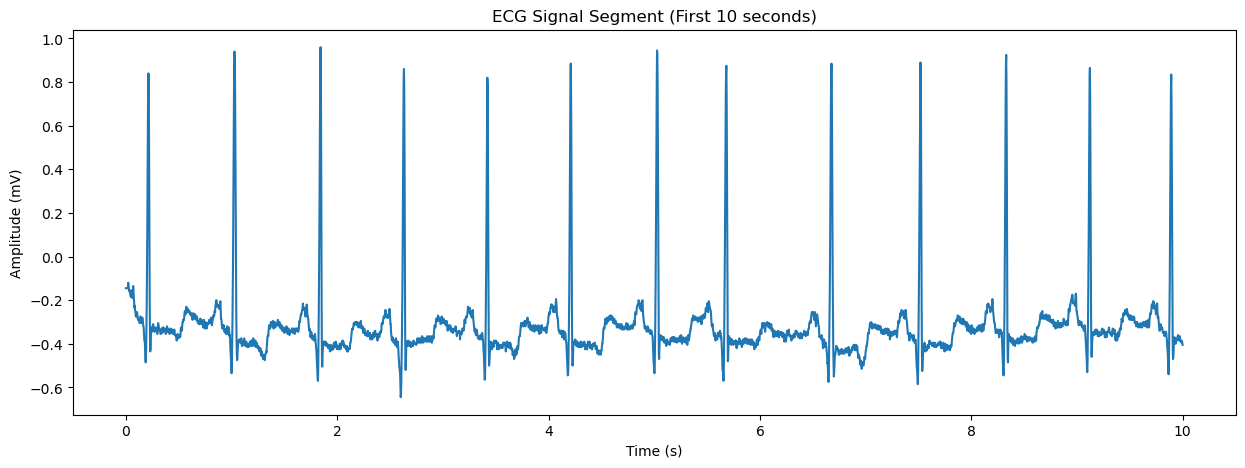

In [169]:
# Define the time range for plotting
start_time = 0  # in seconds
end_time = 10   # in seconds
start_index = start_time * record.fs
end_index = end_time * record.fs

# Extract the signal segment
signal_segment = record.p_signal[int(start_index):int(end_index), 0]  # First channel

# Create time vector for plotting
time_vector = np.linspace(start_time, end_time, len(signal_segment))

# Plot the signal segment
plt.figure(figsize=(15, 5))
plt.plot(time_vector, signal_segment)
plt.title('ECG Signal Segment (First 10 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

## Annotations and Heartbeat Types

### Analysing ECG Annotations
Annotations provide event markers within the signal, such as heartbeat types, signal quality changes, rhythm changes, etc.

In [172]:
# Print unique values from annotation.symbol
unique_symbols = set(annotation.symbol)
print(unique_symbols)

{'A', '+', 'V', 'N'}


In [173]:
print(annotation.aux_note)

['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

### Mapping Annotation Symbols to Beat Types
We map annotation symbols to specific beat types using PhysioBank's symbols.

* To filter annotation that correspond to heartbeats from the rest.
* `beat_symbols`: List of recognized heartbeat symbols.
* `beats_ann_df`: DataFrame containing only heartbeat annotations.

In [175]:
# Define the list of beat symbols as in PhysioBank Annotations
beat_symbols = [
    'N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?'
]

# Create a DataFrame of annotations
annotations_df = pd.DataFrame({
    'Time': annotation.sample / record.fs,
    'Sample': annotation.sample,
    'Symbol': annotation.symbol
})

# Filter the DataFrame to include only rows where the Symbol is a beat type
beats_ann_df = annotations_df[annotations_df['Symbol'].isin(beat_symbols)]

# Display the first few annotations
beats_ann_df.head()

,Time,Sample,Symbol
1,0.213889,77,N
2,1.027778,370,N
3,1.838889,662,N
4,2.627778,946,N
5,3.419444,1231,N


### Plotting Heartbeats with Annotations
We'll plot a segment of the ECG signal with annotations to visualize beat types.

* To visualize where different types of heartbeats occur in the signal.
* **Annotations**: Vertical dashed lines indicate the occurrence of annotated beats.
* **Symbols**: Beat types are labeled next to their corresponding annotations.

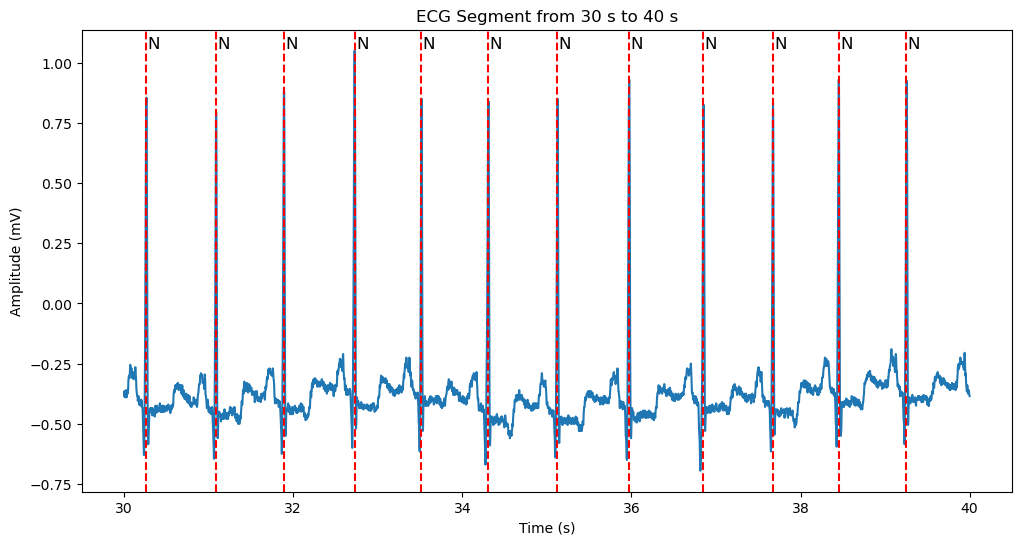

In [177]:
# Define the time window
t_start = 30  # Start time in seconds
t_end = 40    # End time in seconds

# Calculate the indices for the window
start_index = int(t_start * record.fs)
end_index = int(t_end * record.fs)

# Extract the signal segment
signal_segment = record.p_signal[start_index:end_index, 0]  # Assuming the first channel
time_vector = np.linspace(t_start, t_end, len(signal_segment))

# Plot the signal segment
plt.figure(figsize=(12, 6))
plt.plot(time_vector, signal_segment)
plt.title(f'ECG Segment from {t_start} s to {t_end} s')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

# Find all beat annotations within the time window
indices_within_window = np.where((annotation.sample >= start_index) & (annotation.sample < end_index))[0]

# Adjust y position to be at the bottom of the graph
y_min, y_max = plt.ylim()
y_text = y_max - 0.09

# Define an x-offset for the text to shift it to the right of the vertical line
x_offset = (t_end - t_start) * 0.009  # 0.5% of the time window duration

# Loop through the beat annotations within the window
for idx in indices_within_window:
    sample = annotation.sample[idx]
    symbol = annotation.symbol[idx]
    x_pos = sample / record.fs  # Convert sample index to time
    plt.axvline(x_pos, color='red', linestyle='--')
    plt.text(x_pos + x_offset, y_text, symbol,
             color='black', fontsize=12, ha='center', va='bottom')

plt.show()

## Heart Rate Analysis

### Instantaneous Heart Rate Calculation
Heart rate can be calculated from the time intervals between consecutive heartbeats.
* Instantaneous heart rate is the reciprocal of RR intervals multiplied by 60 to convert to bpm.

Mean Heart Rate: 75.82 bpm
Heart Rate Standard Deviation: 5.08 bpm


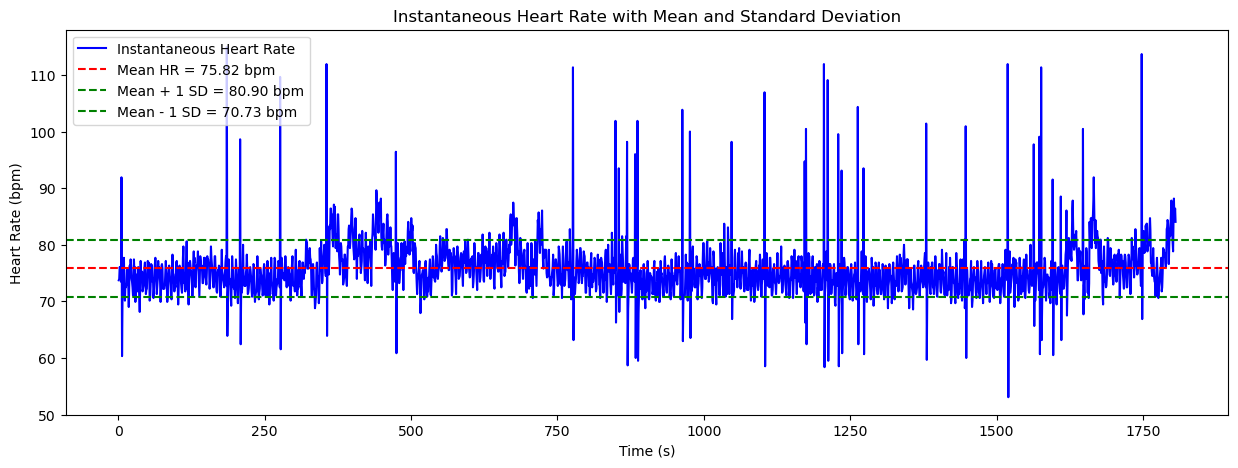

In [180]:
# Calculate RR intervals (in seconds)
rr_intervals = np.diff(beats_ann_df['Sample']) / record.fs

# Calculate instantaneous heart rate (in bpm)
heart_rates = 60 / rr_intervals

# Calculate time points for heart rates (exclude the first beat)
heart_rate_times = beats_ann_df['Sample'][1:] / record.fs

# Compute mean and standard deviation of heart rates
mean_hr = np.mean(heart_rates)
std_hr = np.std(heart_rates)

# Display the mean and standard deviation values
print(f"Mean Heart Rate: {mean_hr:.2f} bpm")
print(f"Heart Rate Standard Deviation: {std_hr:.2f} bpm")

# Plot the heart rate over time
plt.figure(figsize=(15, 5))
plt.plot(heart_rate_times, heart_rates, label='Instantaneous Heart Rate', color='blue')

# Add horizontal lines for mean and standard deviations
plt.axhline(mean_hr, color='red', linestyle='--', label=f'Mean HR = {mean_hr:.2f} bpm')
plt.axhline(mean_hr + std_hr, color='green', linestyle='--', label=f'Mean + 1 SD = {mean_hr + std_hr:.2f} bpm')
plt.axhline(mean_hr - std_hr, color='green', linestyle='--', label=f'Mean - 1 SD = {mean_hr - std_hr:.2f} bpm')

# Add labels and title
plt.title('Instantaneous Heart Rate with Mean and Standard Deviation')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Heart Rate Statistics
We compute some statistical measures of the heart rate, using the describe function.

* To understand the distribution of the heart rates in the record.
* A relatively low standard deviation indicates consistent heart rate and vice versa.
* If the maximum heart rate is siginificantly higher than the mean, it possibly indicates an outlier or an arrythmic event.

In [182]:
# Create a DataFrame for heart rates
hr_df = pd.DataFrame({
    'Time': beats_ann_df['Sample'][1:] / record.fs,
    'HeartRate': heart_rates
})

# Display statistics
print("Heart Rate Statistics:")
print(hr_df['HeartRate'].describe())

Heart Rate Statistics:
count    2272.000000
mean       75.816876
std         5.084609
min        53.071253
25%        72.972973
50%        75.261324
75%        77.697842
max       114.893617
Name: HeartRate, dtype: float64


## Analyzing Arrhythmia Types

### Identifying Different Arrhythmia types
We can focus on specific arrhythmia types by filtering annotations.
* To extract annotations corresponding to arrhythmias.
* **'+' Symbol**: Indicates rhythm change annotations.
* `arrhythmias_df`: Contains arrhythmia events with their samples and types.

In [185]:
# Ensure 'annotation.symbol' is treated as a numpy array
symbols = np.array(annotation.symbol)
aux_notes = np.array(annotation.aux_note)
samples = np.array(annotation.sample)

# Get indices where the symbol is "+"
plus_indices = symbols == '+'

# Extract values at these indices
plus_symbols = symbols[plus_indices]
plus_aux_notes = aux_notes[plus_indices]
plus_samples = samples[plus_indices]

# Create a DataFrame
arrhythmias_df = pd.DataFrame({
    'Sample': plus_samples,
    'Symbol': plus_symbols,
    'Arrhythmia': plus_aux_notes
})

display(arrhythmias_df)

,Sample,Symbol,Arrhythmia
0,18,+,(N


## Visualizing Arrhythmias (Abnormal rhythm of the heart)

### Plotting Arrhythmia
Visualizing an arrhythmic event in the ECG signal.
* Highlights the location of arrhythmias within the signal segment.
* Having many plots allows comparison of different arrhythmia types.

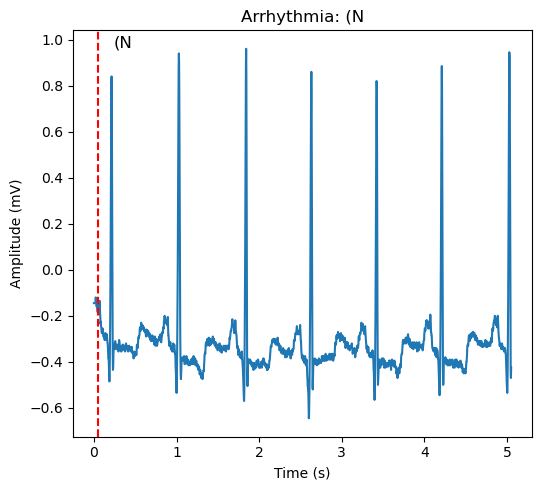

In [188]:
# Get the unique arrhythmia symbols
unique_arrhythmias = arrhythmias_df['Arrhythmia'].unique()

# If there are more than 9 unique arrhythmias, select 9 randomly
if len(unique_arrhythmias) > 9:
    selected_arrhythmias = np.random.choice(unique_arrhythmias, 9, replace=False)
else:
    selected_arrhythmias = unique_arrhythmias

# Initialize the figure for multiple subplots
num_arrhythmias = len(selected_arrhythmias)
rows = int(np.ceil(num_arrhythmias / 3))  # Arrange subplots in 3 columns
plt.figure(figsize=(15, 5 * rows))

# Loop through the selected arrhythmias
for i, arrhythmia_symbol in enumerate(selected_arrhythmias):
    # Find all occurrences of the current arrhythmia
    arrhythmia_events = arrhythmias_df[arrhythmias_df['Arrhythmia'] == arrhythmia_symbol]
    
    # Select a random event if multiple occurrences exist
    arrhythmia_event = arrhythmia_events.sample(n=1).iloc[0]
    
    # Get the sample index of the arrhythmia event
    arrhythmia_sample = arrhythmia_event['Sample']
    
    # Define a time window around the arrhythmia
    window_size = 5  # in seconds
    start_index = int(max(0, arrhythmia_sample - window_size * record.fs))
    end_index = int(min(len(record.p_signal), arrhythmia_sample + window_size * record.fs))
    
    # Extract the signal segment
    signal_segment = record.p_signal[start_index:end_index, 0]
    time_vector = np.linspace(0, (end_index - start_index) / record.fs, len(signal_segment))
    
    # Create a subplot
    plt.subplot(rows, 3, i + 1)
    plt.plot(time_vector, signal_segment)
    plt.title(f'Arrhythmia: {arrhythmia_symbol}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    
    # Mark the arrhythmia location
    x_pos = (arrhythmia_sample - start_index) / record.fs
    plt.axvline(x_pos, color='red', linestyle='--')
    
    # Adjust y position to be at the bottom of the graph
    y_min, y_max = plt.ylim()
    offset = 0.05 * (y_max - y_min)
    y_text = y_max - offset
    
    # Add the arrhythmia symbol text at the bottom of the plot
    plt.text(x_pos + 0.3, y_text, arrhythmia_symbol,
             color='black', fontsize=12, ha='center', va='bottom')
    
    # Tighten the layout
    plt.tight_layout()

plt.show()

## Conclusion EDA on single signal
The MIT-BIH Arrhythmia Database provides a rich dataset for exploring ECG signals and arrhythmias. Through this single signal EDA, we have:

* Examined the structure and content of ECG recordings.
* Visualized normal and arrhythmic heartbeats.
* Analyzed the distribution of heartbeat types.
* Calculated and explored heart rate variability.

# Data Processing and Analysis on Normal ECGs
Analysis is extended to multiple ECG records, focusing on normal heart rhythms

## Data Preparation

### Initializing Data Structures
We will create empty lists or DataFrames to store aggregated data. To prepare for data aggregation across multiple records.

In [193]:
# Initialize lists to store data
all_ann_df = pd.DataFrame()
all_beats_df = pd.DataFrame()
all_hr_df = pd.DataFrame()
symbol_counts_total = pd.Series(dtype=int)

### Looping Through Records
We will iterate over each record, perform the analysis, and collect the results.
* To collect annotations, heartbeats, and heart rate data from multiple records
* Data from each record is concatenated to the overall DataFrames
* Records number 110 and 120 are excluded from the array, because these don't exist in the database

In [195]:
# List of record numbers to analyze (as strings)
record_numbers = [str(num) for num in range(100, 125) if num not in {110, 120}]

In [196]:
for record_number in record_numbers:
    # Load the record
    record_path = f'../Data/mitbih_data/{record_number}'
    record = wfdb.rdrecord(record_path)
    
    # Load the annotation
    annotation = wfdb.rdann(record_path, 'atr')
    
    # Create a DataFrame of annotations
    ann_df = pd.DataFrame({
        'Record': record_number,
        'Time': annotation.sample / record.fs,
        'Sample': annotation.sample,
        'Symbol': annotation.symbol,
        'Aux_Note': annotation.aux_note
    })
    
    # Append to the aggregated annotation DataFrame
    all_ann_df = pd.concat([all_ann_df, ann_df], ignore_index=True)
    
    # Filter the DataFrame to include only rows where the Symbol is a beat type
    beats_ann_df = ann_df[ann_df['Symbol'].isin(beat_symbols)]

    all_beats_df = pd.concat([all_beats_df, beats_ann_df], ignore_index=True)
    
    # Calculate RR intervals and heart rates
    rr_intervals = np.diff(beats_ann_df['Sample']) / record.fs
    heart_rates = 60 / rr_intervals
    
    # Create a DataFrame for heart rates
    hr_df = pd.DataFrame({
        'Record': record_number,
        'Time': beats_ann_df['Sample'][1:] / record.fs,
        'HeartRate': heart_rates
    })
    
    # Append to the aggregated heart rate DataFrame
    all_hr_df = pd.concat([all_hr_df, hr_df], ignore_index=True)
    
    # Update symbol counts
    symbol_counts = ann_df['Symbol'].value_counts()
    symbol_counts_total = symbol_counts_total.add(symbol_counts, fill_value=0)

## Aggregated Analysis
Now that we have collected data from multiple records, we can perform aggregated analyses.

### Overall Distribution of Heartbeat Types
* To visualize the frequency of different heartbeat types across records.
* The nomral beat 'N' is the most common, as expected.

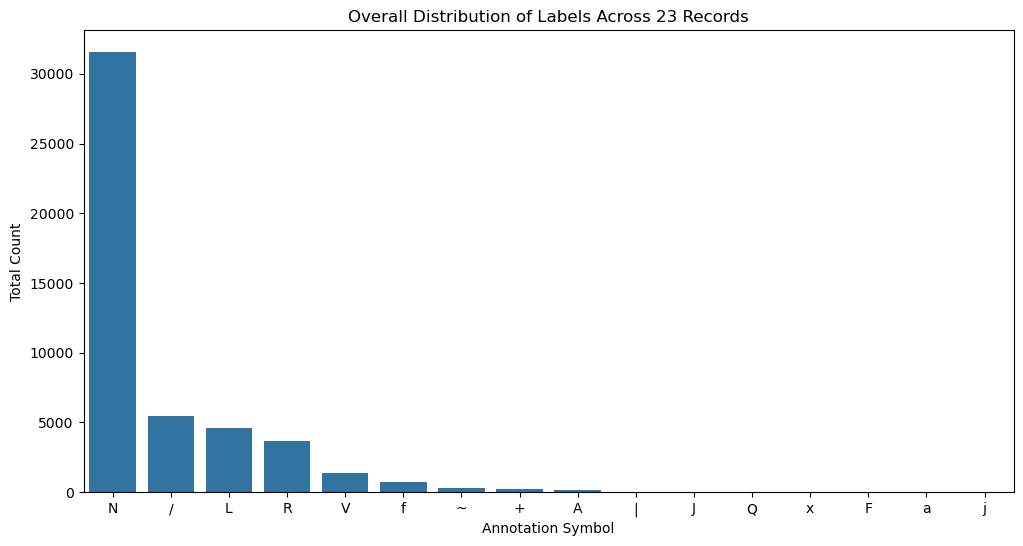

In [199]:
# Plot the overall distribution of heartbeat types
plt.figure(figsize=(12, 6))
symbol_counts_total_sorted = symbol_counts_total.sort_values(ascending=False)
sns.barplot(x=symbol_counts_total_sorted.index, y=symbol_counts_total_sorted.values)
plt.title('Overall Distribution of Labels Across 23 Records')
plt.xlabel('Annotation Symbol')
plt.ylabel('Total Count')
plt.show()

### Removing records with Paced Beats
Some records contain paced beats, which could skew the analysis

In [201]:
# Define the records to remove
records_to_remove = ['102', '104', '107', '217']

# Filter all_ann_df
all_ann_df = all_ann_df[~all_ann_df['Record'].isin(records_to_remove)]

# Filter all_hr_df
all_hr_df = all_hr_df[~all_hr_df['Record'].isin(records_to_remove)]

# Filter all_beats_df
all_beats_df = all_beats_df[~all_beats_df['Record'].isin(records_to_remove)]

### Heart Rate Statistics Across Records
Heart rate statistics are calculated for each record, to compare the heart rate variability between different subjects.

In [203]:
# Compute heart rate statistics for each record
hr_stats = all_hr_df.groupby('Record')['HeartRate'].describe()

# Display the heart rate statistics
print("Heart Rate Statistics Across Records:")
display(hr_stats)

Heart Rate Statistics Across Records:


,count,mean,std,min,25%,50%,75%,max
Record,,,,,,,,
100,2272.0,75.816876,5.084609,53.071253,72.972973,75.261324,77.697842,114.893617
101,1864.0,62.318684,4.809568,31.764706,59.178082,61.363636,64.285714,111.340206
103,2083.0,69.470401,3.927021,53.731343,66.873065,69.009585,71.287129,92.703863
105,2571.0,86.236827,8.689063,41.941748,82.442748,85.375494,88.524590,156.521739
106,2026.0,74.856075,26.465569,39.926063,56.250000,64.094955,104.222408,143.046358
108,1762.0,59.528942,8.381712,35.064935,55.384615,58.378378,62.608696,140.259740
109,2531.0,84.372078,4.596838,65.256798,81.509434,84.046693,86.746988,116.756757
111,2123.0,70.747923,3.281834,58.536585,68.571429,70.358306,72.727273,98.181818
112,2538.0,84.449540,2.581465,62.247839,82.758621,84.375000,86.055777,113.089005


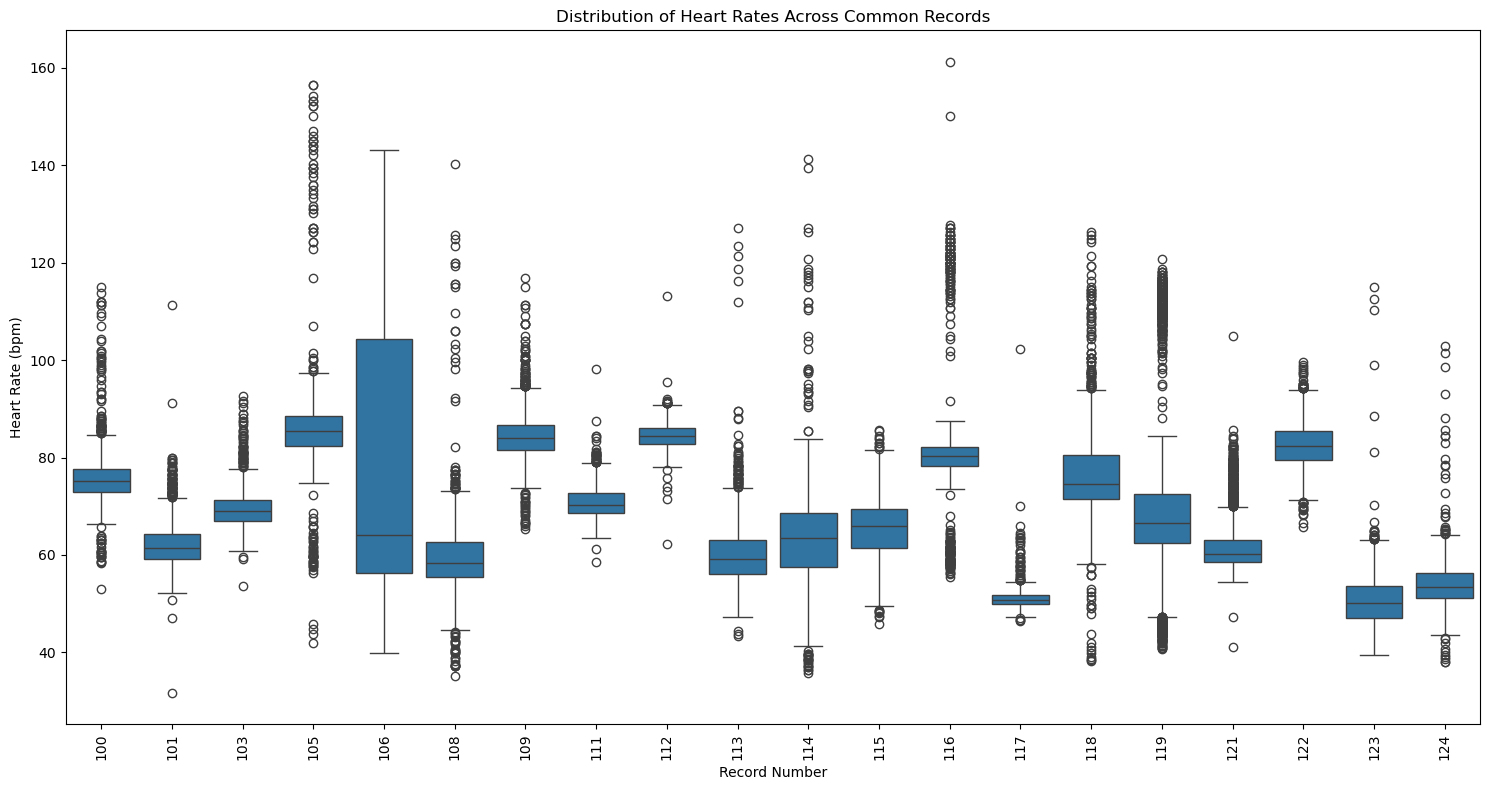

In [204]:
# Ensure 'all_hr_df' has columns 'Record' and 'HeartRate'

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a box plot
sns.boxplot(x='Record', y='HeartRate', data=all_hr_df)

# Set plot title and labels
plt.title('Distribution of Heart Rates Across Common Records')
plt.xlabel('Record Number')
plt.ylabel('Heart Rate (bpm)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()

### Plotting Heart Rate Distributions
Heart rate distributions for a subset of records are plotted.

* To visualize the distribution and variability of heart rates among subjects.
* It's possible to observe that these distributions vary between individuals.

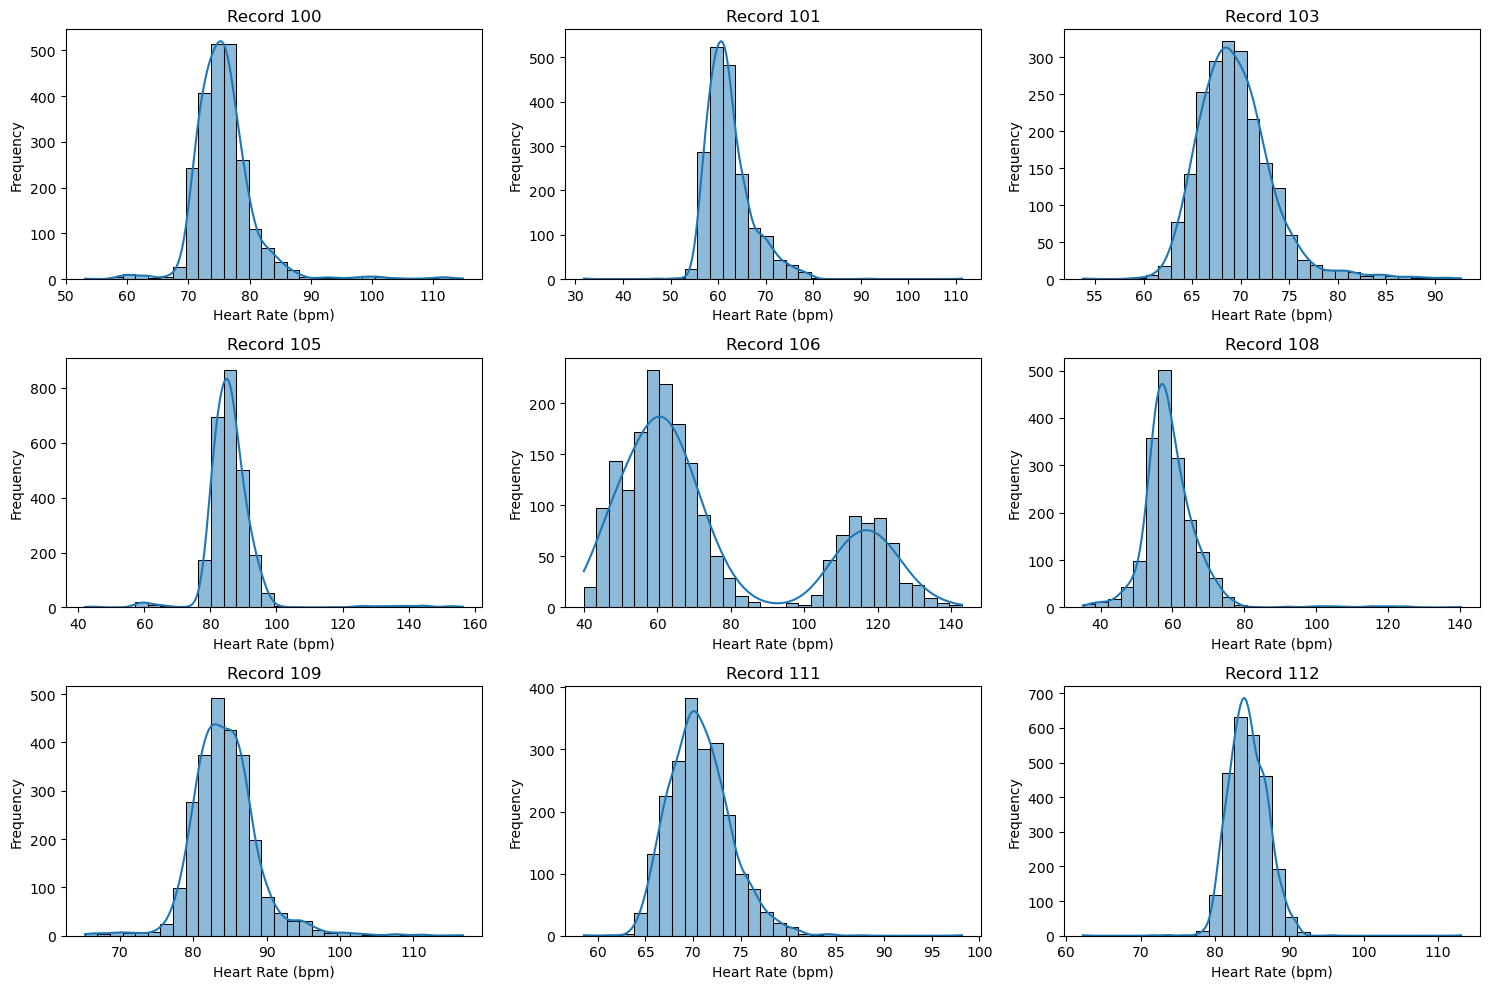

In [206]:
# Plot heart rate distributions for each record
plt.figure(figsize=(15, 10))

# Define the string records to exclude
records_to_exclude = ['102', '104', '107', '217']

# Filter out the excluded records
record_numbers_no_paced = [record for record in record_numbers if record not in records_to_exclude]
records_to_plot = record_numbers_no_paced[:9]  # Select a few records for plotting

for i, rec in enumerate(records_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(all_hr_df[all_hr_df['Record'] == rec]['HeartRate'], bins=30, kde=True)
    plt.title(f'Record {rec}')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Comparing Heartbeat Type Distributions Across Records

1. A Pivot table is created to show the count of each heartbeat type for every record
    * Some records have higher occurences of specific heartbeat types
2. A Heatmap is plotted to visualize heartbeat type counts across records
    * Easier to identify patterns and records with higher occurrences of certain beat types 

In [208]:
# Pivot the data to create a matrix of counts per record and symbol
symbol_counts_matrix = all_beats_df.pivot_table(
    index='Record',
    columns='Symbol',
    aggfunc='size',
    fill_value=0
)

# Display the matrix
print("Heartbeat Type Counts per Record:")
display(symbol_counts_matrix.head())

Heartbeat Type Counts per Record:


Symbol,A,F,J,L,N,Q,R,V,a,j
Record,,,,,,,,,,
100,33,0,0,0,2239,0,0,1,0,0
101,3,0,0,0,1860,2,0,0,0,0
103,2,0,0,0,2082,0,0,0,0,0
105,0,0,0,0,2526,5,0,41,0,0
106,0,0,0,0,1507,0,0,520,0,0


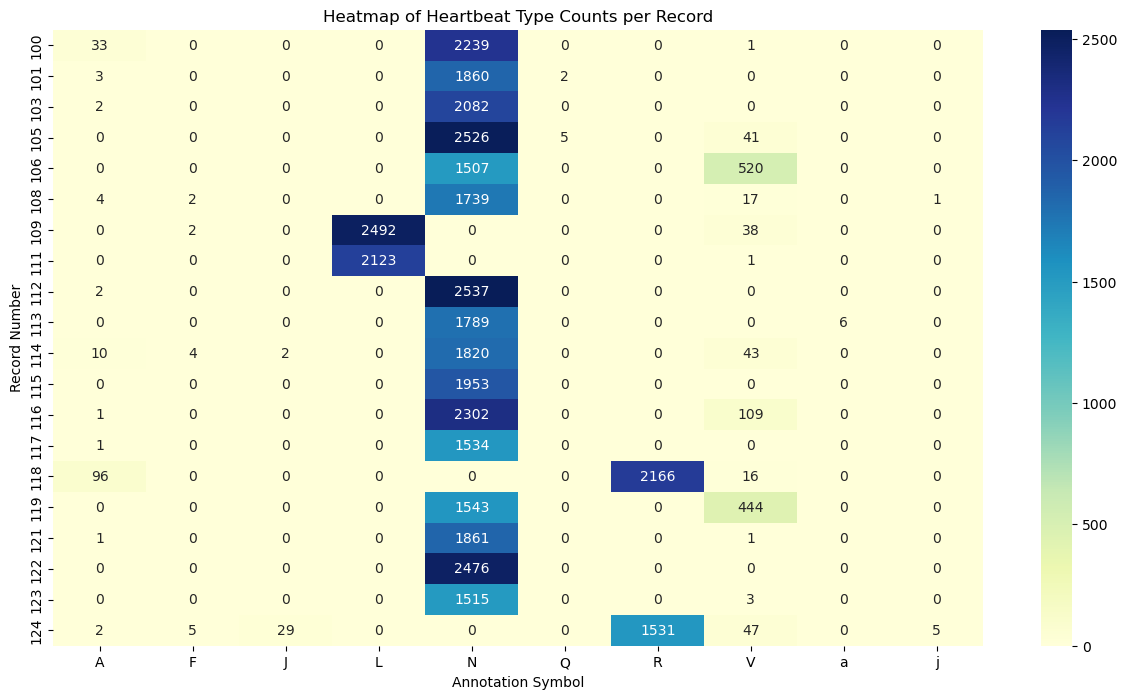

In [209]:
# Plot a heatmap of heartbeat type counts per record
plt.figure(figsize=(15, 8))
sns.heatmap(symbol_counts_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Heartbeat Type Counts per Record')
plt.xlabel('Annotation Symbol')
plt.ylabel('Record Number')
plt.show()

## Arrhythmia Analysis Across Records

### Identifying Records with Specific Arrhythmias
We find records containing specific arrhythmias by filtering annotations.

* Arrhythmic events are counted per record
* Record 119 has the highest number of arrhythmic events

In [212]:
# Get unique values from the "Aux_Note" column - Representing different Rhythm Changes (Possible Arrhythmias)
unique_aux_notes = all_ann_df['Aux_Note'].unique()
print(unique_aux_notes)

['(N\x00' '' '(B\x00' '(VT\x00' '(T\x00' '(SVTA\x00' '(NOD\x00' '(IVR\x00']


In [213]:
# Define arrhythmia symbols to look for
arrhythmia_notes = [note for note in unique_aux_notes if note != '']

# Filter annotations for arrhythmias
arrhythmia_ann_all = all_ann_df[all_ann_df['Aux_Note'].isin(arrhythmia_notes)]

# Get the count of arrhythmic events per record
arrhythmia_counts = arrhythmia_ann_all['Record'].value_counts()

# Display the records with arrhythmias
print("Number of Arrhythmic Events per Record:")
print(arrhythmia_counts)

Number of Arrhythmic Events per Record:
Record
119    103
106     41
124     13
114      3
105      1
109      1
111      1
112      1
113      1
101      1
115      1
116      1
117      1
118      1
103      1
121      1
122      1
123      1
100      1
Name: count, dtype: int64


### Plotting Arrhythmia Occurences

The frequency of arrhythmic events across records are visualized
* This way, it's possible easily identify the records with significant amount of arrhythmias

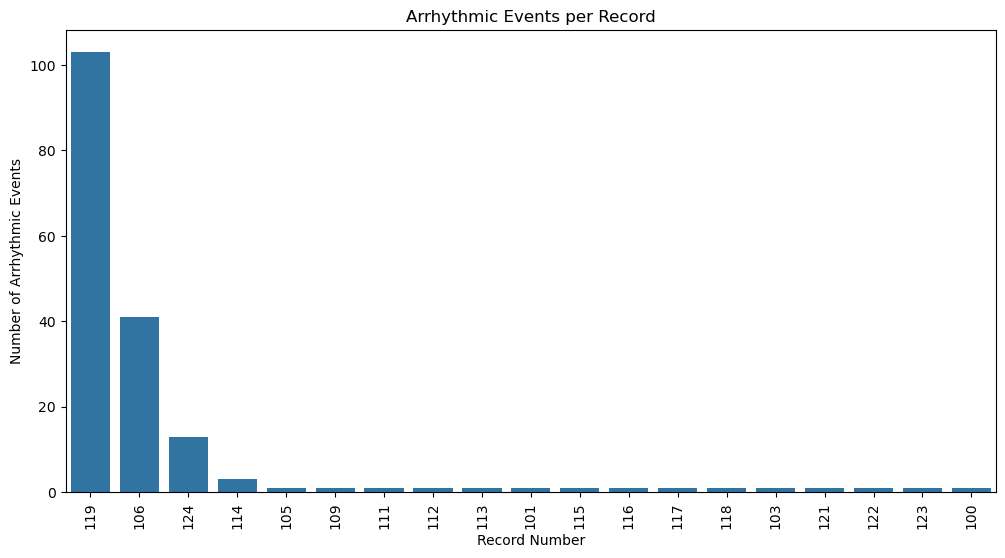

In [215]:
# Plot the number of arrhythmic events per record
plt.figure(figsize=(12, 6))
sns.barplot(x=arrhythmia_counts.index, y=arrhythmia_counts.values)
plt.title('Arrhythmic Events per Record')
plt.xlabel('Record Number')
plt.ylabel('Number of Arrhythmic Events')
plt.xticks(rotation=90)
plt.show()

## Plotting ECG Segments from Multiple Records
Random segments from different records are selected to compare ECG waveforms.

* The morphology across different records can vary. This way, that can be observed.

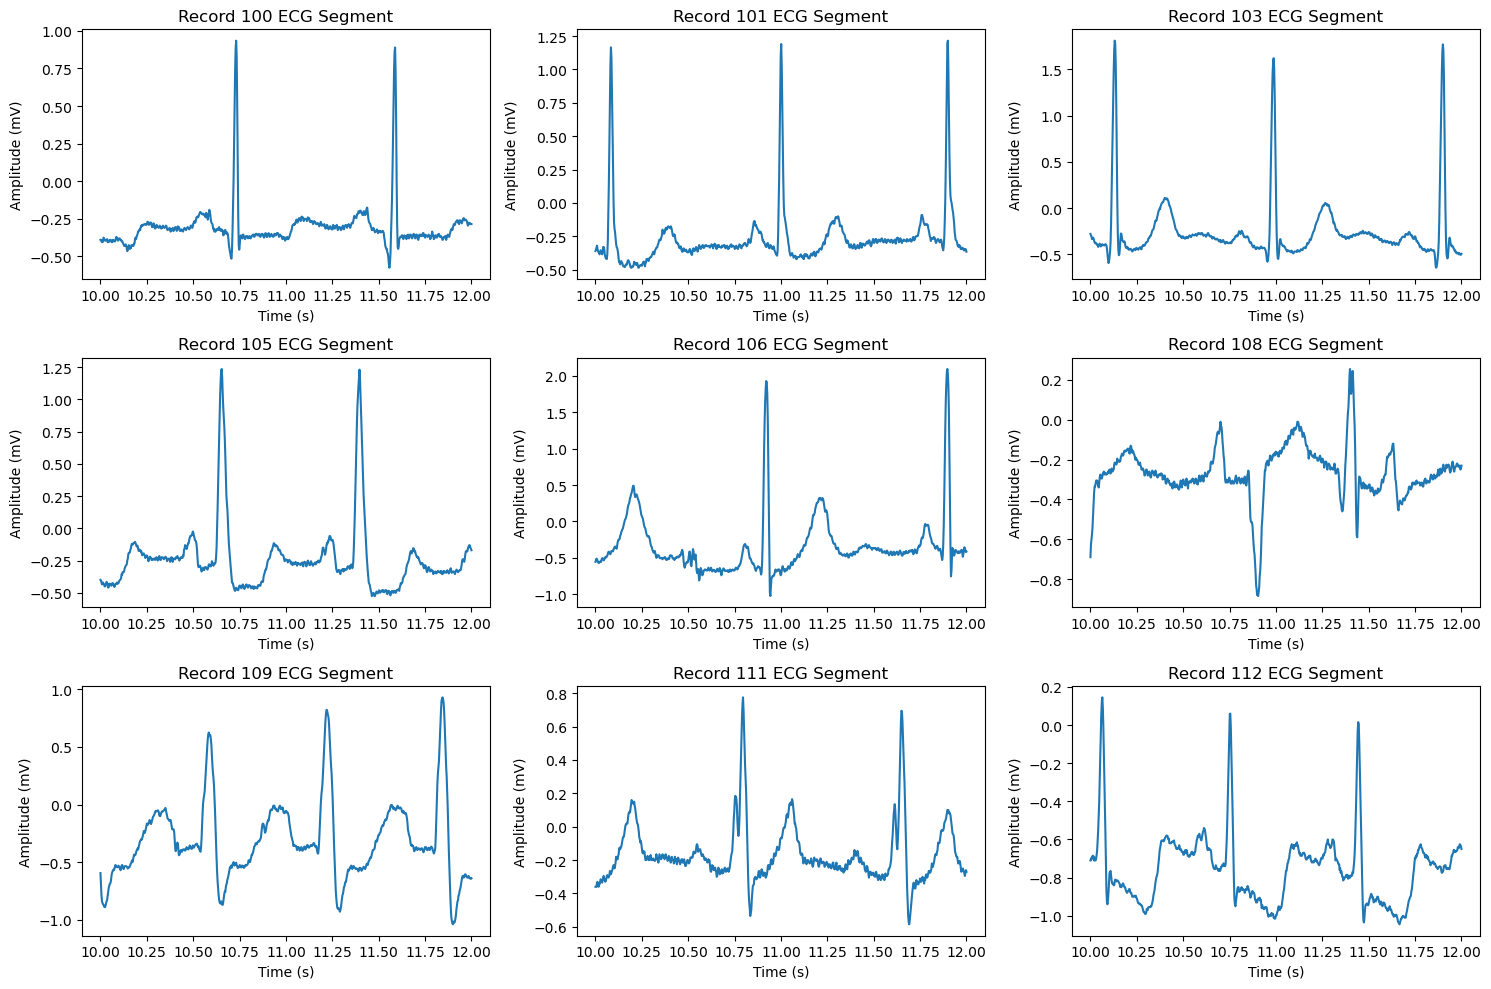

In [217]:
# Plot ECG segments from multiple records
plt.figure(figsize=(15, 10))
for i, rec in enumerate(records_to_plot):
    # Load the record
    record_path = f'../Data/mitbih_data/{rec}'
    record = wfdb.rdrecord(record_path)
    
    # Extract a signal segment (e.g., from 10 to 12 seconds)
    start_time = 10  # in seconds
    end_time = 12
    start_index = int(start_time * record.fs)
    end_index = int(end_time * record.fs)
    signal_segment = record.p_signal[start_index:end_index, 0]
    time_vector = np.linspace(start_time, end_time, len(signal_segment))
    
    # Plot the signal segment
    plt.subplot(3, 3, i+1)
    plt.plot(time_vector, signal_segment)
    plt.title(f'Record {rec} ECG Segment')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')

plt.tight_layout()
plt.show()

## Calculating HRV (Heart Rate Variability) Metrics
HRV metrics such as SDNN (Standard Deviation of NN Intervals) are calculated for each record.

* To analyze the autonomic regulation of the heart.
* **Metrics**:
    * **SDNN**: Indicates overall HRV
    * **RMSSD**: Reflects short-term veriability
* The HRV metrics are then plotted across records, for better understanding
    * Records with higher SDNN and RMSSD values have higher HRV

In [250]:
# Initialize a list to store HRV metrics
hrv_metrics_list = []

for rec in record_numbers_no_paced:
    # Get RR intervals for the record
    rr_intervals = all_hr_df[all_hr_df['Record'] == rec]['HeartRate']
    nn_intervals = 60000 / rr_intervals  # Convert bpm to NN intervals in ms
    
    # Calculate HRV metrics
    sdnn = np.std(nn_intervals)
    mean_nn = np.mean(nn_intervals)
    rmssd = np.sqrt(np.mean(np.diff(nn_intervals) ** 2))
    
    # Append metrics to the DataFrame
    hrv_metrics_list.append({
        'Record': rec,
        'SDNN': sdnn,
        'MeanNN': mean_nn,
        'RMSSD': rmssd
    })

# Create a DataFrame from the list of dictionaries
hrv_metrics = pd.DataFrame(hrv_metrics_list)

# Display HRV metrics
print("HRV Metrics per Record:")
display(hrv_metrics)

HRV Metrics per Record:


,Record,SDNN,MeanNN,RMSSD
0,100,48.835396,794.593603,63.231788
1,101,70.992165,968.150930,54.993880
2,103,46.423407,866.285272,33.369504
3,105,64.715280,701.783785,94.812725
4,106,260.969874,890.424482,434.853056
5,108,124.116156,1024.216484,146.638220
6,109,37.849284,713.178805,44.969790
7,111,38.369302,849.854765,36.546759
8,112,21.740957,711.145040,20.088531
9,113,99.114553,1006.168711,102.841549


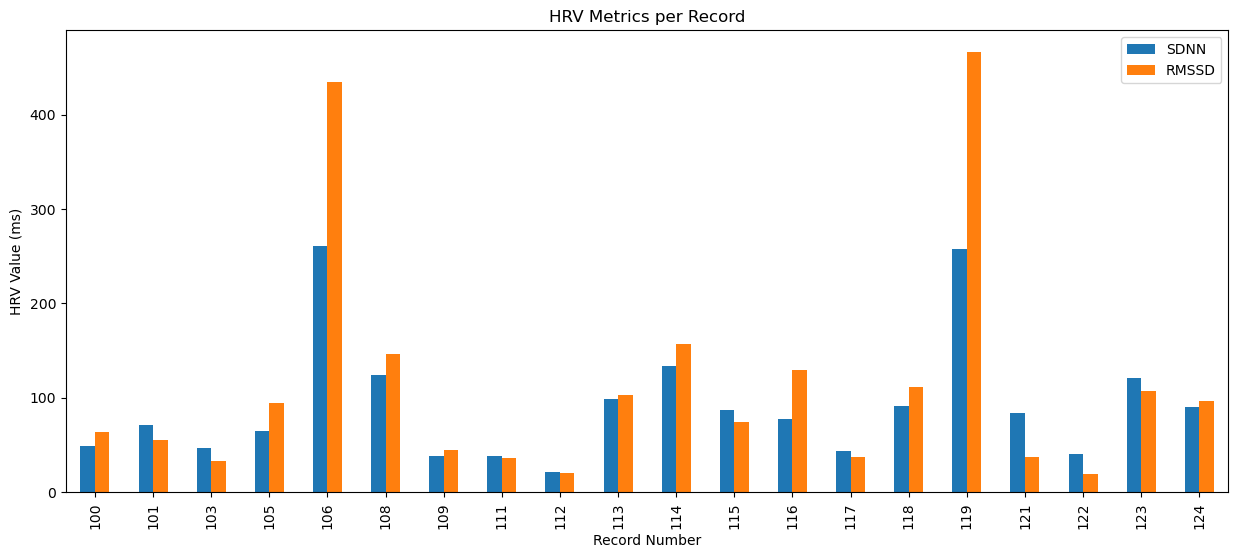

In [252]:
# Plot HRV metrics
hrv_metrics.set_index('Record', inplace=True)
hrv_metrics[['SDNN', 'RMSSD']].plot(kind='bar', figsize=(15, 6))
plt.title('HRV Metrics per Record')
plt.xlabel('Record Number')
plt.ylabel('HRV Value (ms)')
plt.xticks(rotation=90)
plt.show()

# Data Analysis of the uncommon ECGs

## Processing Uncommon Records
The analysis above is now repeated for the subset of ECG records with uncommon atributes, present in the database.

In [971]:
# Initialize lists to store data
all_ann_df_un = pd.DataFrame()
all_beats_df_un = pd.DataFrame()
all_hr_df_un = pd.DataFrame()
symbol_counts_total_un = pd.Series(dtype=int)

In [972]:
# List of record numbers to analyze (as strings)
record_numbers_uncommon = [str(num) for num in range(200, 235) if num not in {204, 206, 211, 216, 218, 224, 225, 226, 227, 229}]

In [973]:
for record_number in record_numbers_uncommon:
    # Load the record
    record_path = f'../Data/mitbih_data/{record_number}'
    record = wfdb.rdrecord(record_path)
    
    # Load the annotation
    annotation = wfdb.rdann(record_path, 'atr')
    
    # Create a DataFrame of annotations
    ann_df_un = pd.DataFrame({
        'Record': record_number,
        'Time': annotation.sample / record.fs,
        'Sample': annotation.sample,
        'Symbol': annotation.symbol,
        'Aux_Note': annotation.aux_note
    })
    
    # Append to the aggregated annotation DataFrame
    all_ann_df_un = pd.concat([all_ann_df_un, ann_df_un], ignore_index=True)
    
    # Filter the DataFrame to include only rows where the Symbol is a beat type
    beats_ann_df_un = ann_df_un[ann_df_un['Symbol'].isin(beat_symbols)]

    all_beats_df_un = pd.concat([all_beats_df_un, beats_ann_df_un], ignore_index=True)
    
    # Calculate RR intervals and heart rates
    rr_intervals = np.diff(beats_ann_df_un['Sample']) / record.fs
    heart_rates = 60 / rr_intervals
    
    # Create a DataFrame for heart rates
    hr_df_un = pd.DataFrame({
        'Record': record_number,
        'Time': beats_ann_df_un['Sample'][1:] / record.fs,
        'HeartRate': heart_rates
    })
    
    # Append to the aggregated heart rate DataFrame
    all_hr_df_un = pd.concat([all_hr_df_un, hr_df_un], ignore_index=True)
    
    # Update symbol counts
    symbol_counts = ann_df_un['Symbol'].value_counts()
    symbol_counts_total_un = symbol_counts_total_un.add(symbol_counts, fill_value=0)

## Aggregated Analysis for Uncommon Records
Similar analysis as before are performed, but now for uncommon records

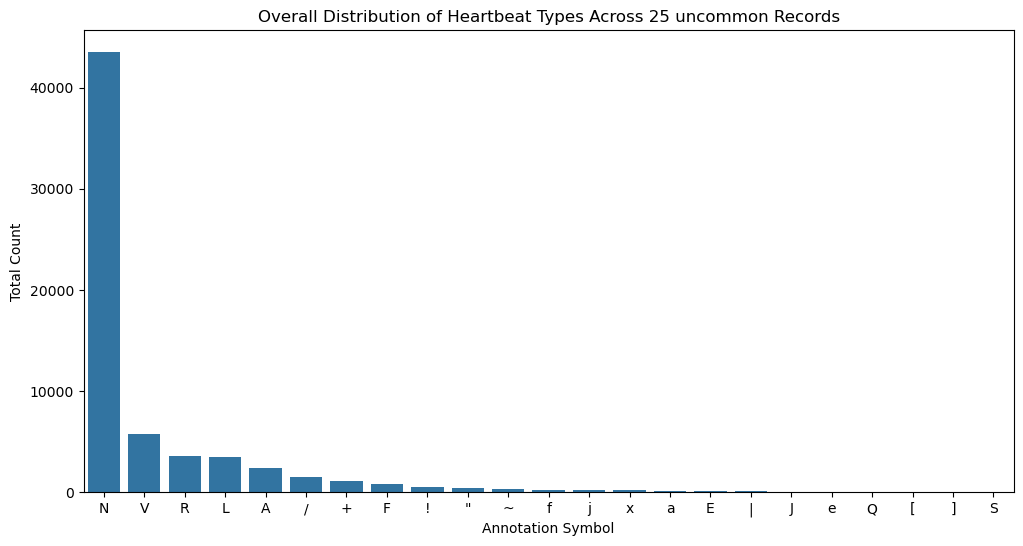

In [974]:
# Plot the overall distribution of heartbeat types
plt.figure(figsize=(12, 6))
symbol_counts_total_sorted_un = symbol_counts_total_un.sort_values(ascending=False)
sns.barplot(x=symbol_counts_total_sorted_un.index, y=symbol_counts_total_sorted_un.values)
plt.title('Overall Distribution of Heartbeat Types Across 25 uncommon Records')
plt.xlabel('Annotation Symbol')
plt.ylabel('Total Count')
plt.show()

### Remove records with paced beats

In [976]:
# Filter all_ann_df_un
all_ann_df_un = all_ann_df_un[~all_ann_df_un['Record'].isin(records_to_remove)]

# Filter all_hr_df_un
all_hr_df_un = all_hr_df_un[~all_hr_df_un['Record'].isin(records_to_remove)]

# Filter all_beats_df_un
all_beats_df_un = all_beats_df_un[~all_beats_df_un['Record'].isin(records_to_remove)]

### Heart rate statistics across uncommon records

In [978]:
# Compute heart rate statistics for each record
hr_stats_un = all_hr_df_un.groupby('Record')['HeartRate'].describe()

# Display the heart rate statistics
print("Heart Rate Statistics Across Uncommon Records:")
display(hr_stats_un)

Heart Rate Statistics Across Uncommon Records:


,count,mean,std,min,25%,50%,75%,max
Record,,,,,,,,
200,2600.0,90.352256,18.499455,45.378151,76.056338,89.626556,104.854369,184.615385
201,1962.0,75.729816,29.791443,15.905744,50.349650,69.565398,94.323144,178.512397
202,2135.0,81.120447,31.261909,36.610169,54.135338,67.711599,105.365854,186.206897
203,2979.0,110.644604,37.214749,32.432432,81.203008,98.181818,144.000000,240.000000
205,2655.0,89.494884,13.684752,53.465347,83.397683,89.256198,91.914894,227.368421
207,1859.0,70.383132,17.702464,0.599867,61.189802,64.477612,75.789474,166.153846
208,2954.0,102.161968,19.187093,19.182948,89.626556,103.846154,113.684211,154.285714
209,3004.0,102.415128,18.847819,69.677419,92.703863,96.000000,102.369668,178.512397
210,2649.0,91.320915,19.962925,40.373832,81.203008,87.449393,96.428571,205.714286


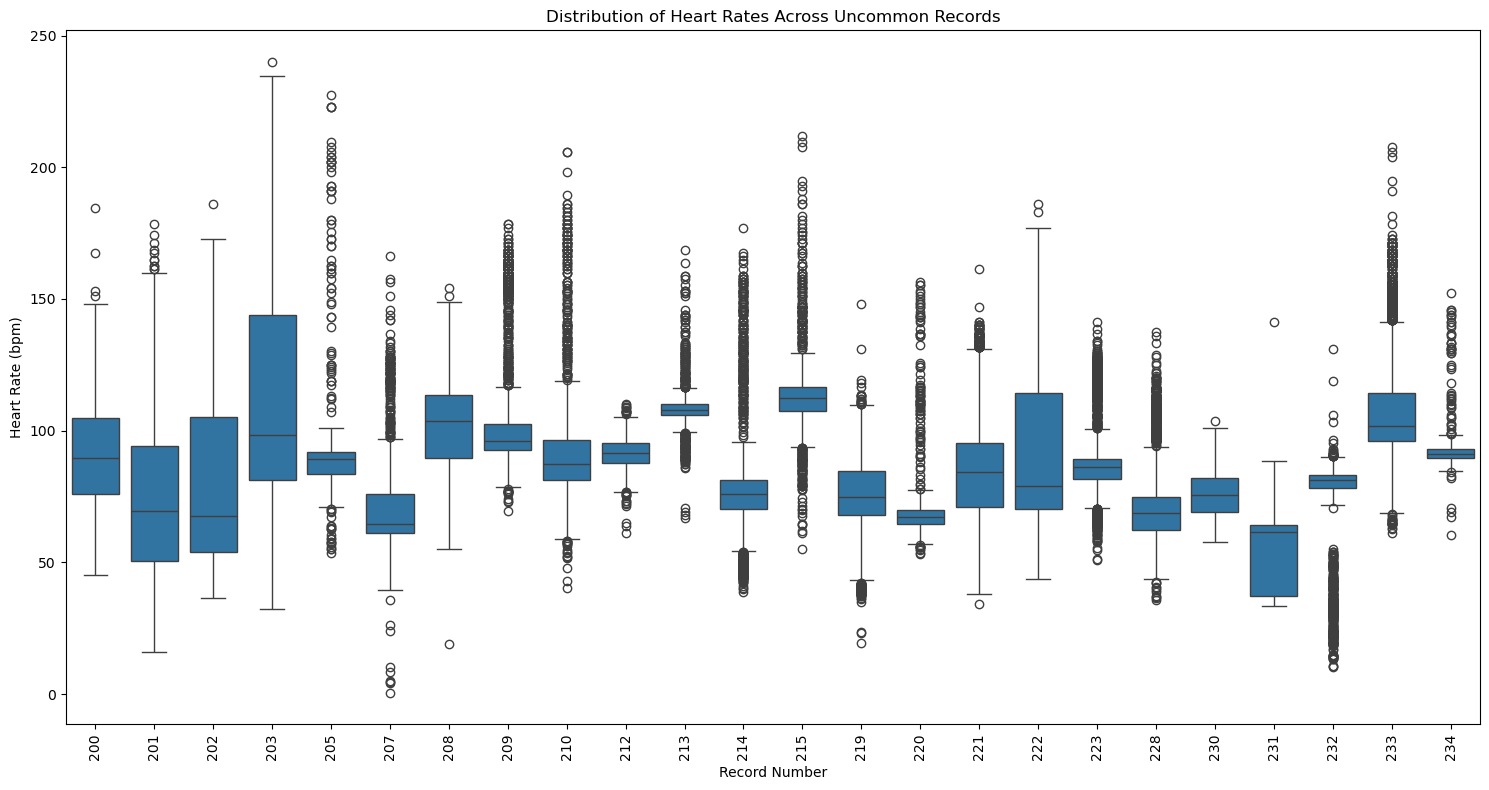

In [979]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Create a box plot
sns.boxplot(x='Record', y='HeartRate', data=all_hr_df_un)

# Set plot title and labels
plt.title('Distribution of Heart Rates Across Uncommon Records')
plt.xlabel('Record Number')
plt.ylabel('Heart Rate (bpm)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()

### Plotting Heart Rate Distributions Uncommon Records

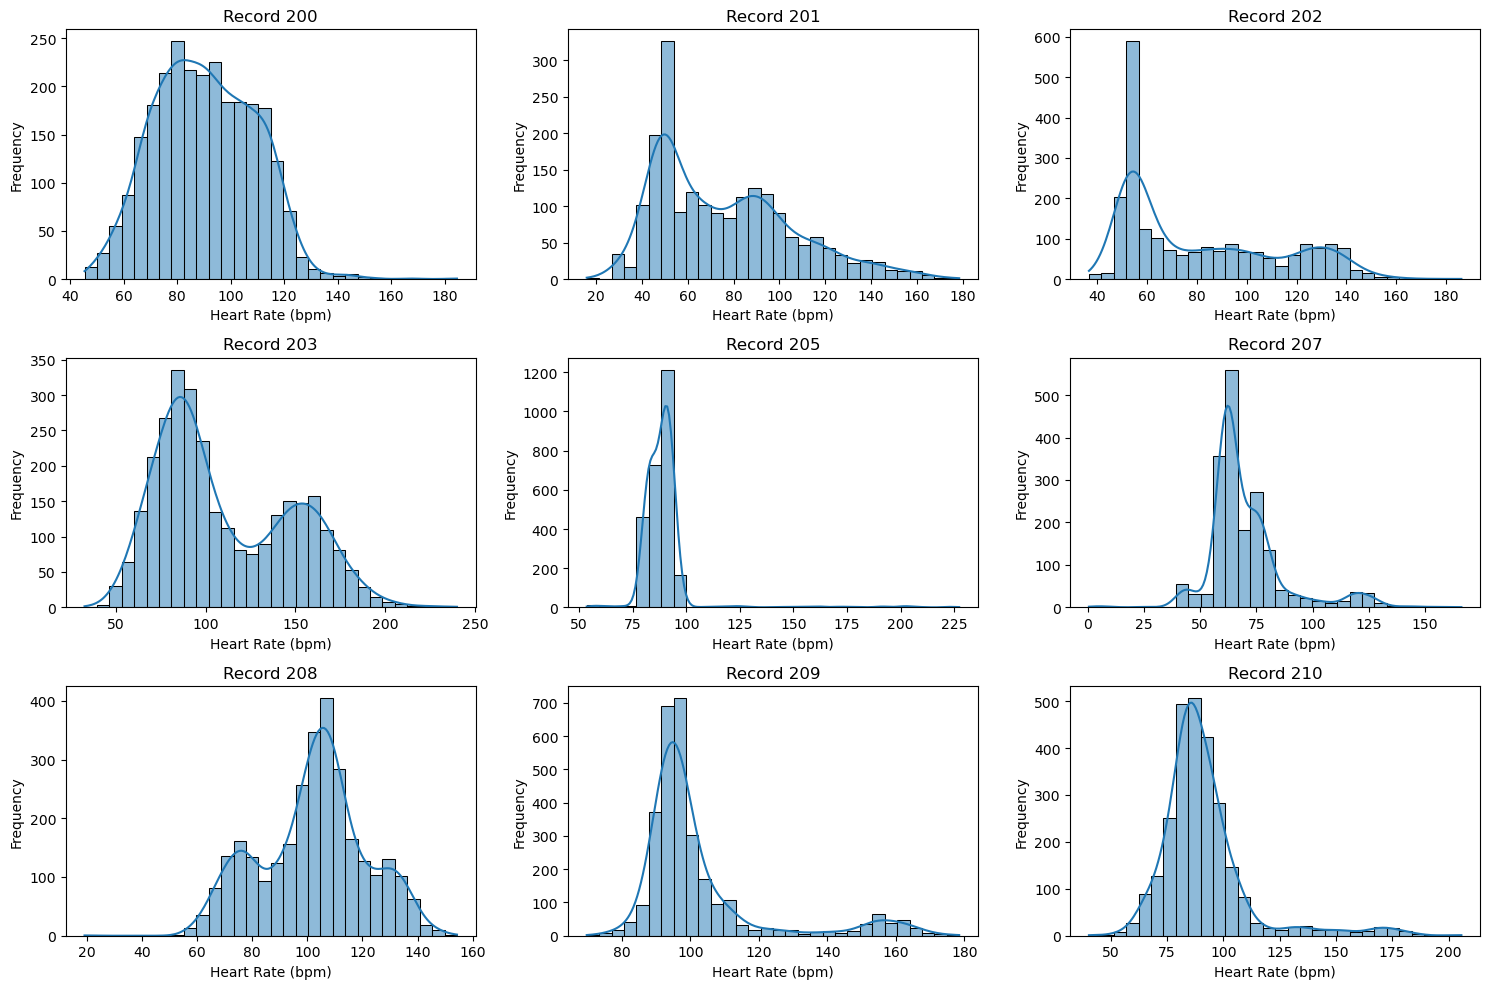

In [981]:
# Plot heart rate distributions for each record
plt.figure(figsize=(15, 10))

# Filter out the excluded records
record_numbers_no_paced_un = [record for record in record_numbers_uncommon if record not in records_to_remove]
records_to_plot_un = record_numbers_no_paced_un[:9]  # Select a few records for plotting

for i, rec in enumerate(records_to_plot_un):
    plt.subplot(3, 3, i+1)
    sns.histplot(all_hr_df_un[all_hr_df_un['Record'] == rec]['HeartRate'], bins=30, kde=True)
    plt.title(f'Record {rec}')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Comparing Heartbeat Type Distributions Across Records

In [983]:
# Pivot the data to create a matrix of counts per record and symbol
symbol_counts_matrix_un = all_beats_df_un.pivot_table(
    index='Record',
    columns='Symbol',
    aggfunc='size',
    fill_value=0
)

# Display the matrix
print("Heartbeat Type Counts per Record:")
display(symbol_counts_matrix_un.head())

Heartbeat Type Counts per Record:


Symbol,A,E,F,J,L,N,Q,R,S,V,a,e,j
Record,,,,,,,,,,,,,
200,30,0,2,0,0,1743,0,0,0,826,0,0,0
201,30,0,2,1,0,1625,0,0,0,198,97,0,10
202,36,0,1,0,0,2061,0,0,0,19,19,0,0
203,0,0,1,0,0,2529,4,0,0,444,2,0,0
205,3,0,11,0,0,2571,0,0,0,71,0,0,0


### Visualizing Heatmap of Heartbeat Types

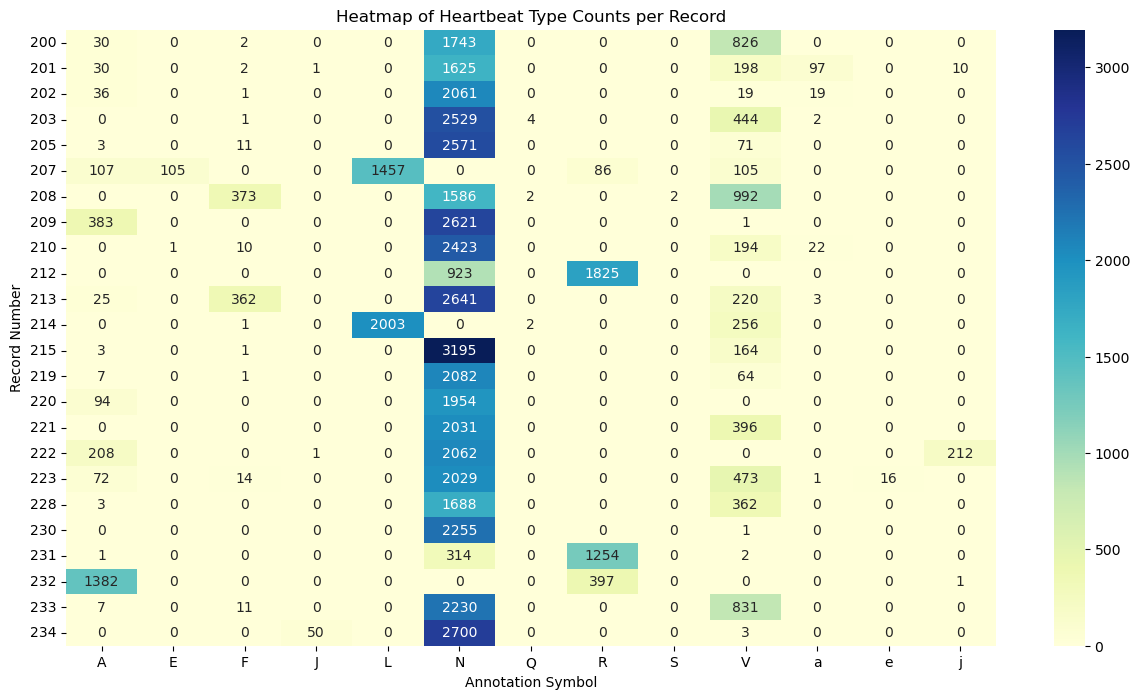

In [985]:
# Plot a heatmap of heartbeat type counts per record
plt.figure(figsize=(15, 8))
sns.heatmap(symbol_counts_matrix_un, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Heartbeat Type Counts per Record')
plt.xlabel('Annotation Symbol')
plt.ylabel('Record Number')
plt.show()

## Arrhythmia Analysis Across Uncommon Records

### Identifying Uncommon Records with Specific Arrhythmias
We first find records that contain specific arrhythmias.

* **Note**: Some of the Rhythm changes don't represent Arrhythmias. P.E. "(N" represents the beggining of a normal Rhythm. 

In [988]:
# Get unique values from the "Aux_Note" column
unique_aux_notes_un = all_ann_df_un['Aux_Note'].unique()
print(unique_aux_notes_un)

['(B\x00' '' '(N\x00' '(VT\x00' '(AFIB\x00' '(NOD\x00' '(T\x00' '(SVTA'
 '(AFL' '(VFL\x00' '(IVR\x00' 'TS\x00' 'PSE\x00' 'MISSB\x00' '(AB\x00'
 '(PREX\x00' '(BII\x00' '(SBR\x00']


In [989]:
# Define arrhythmia symbols to look for
arrhythmia_notes_un = [note for note in unique_aux_notes_un if note != '']

# Filter annotations for arrhythmias
arrhythmia_ann_all_un = all_ann_df_un[all_ann_df_un['Aux_Note'].isin(arrhythmia_notes_un)]

# Get the count of arrhythmic events per record
arrhythmia_counts_un = arrhythmia_ann_all_un['Record'].value_counts()

# Display the records with arrhythmias
print("Number of Arrhythmic Events per Uncommon Record:")
print(arrhythmia_counts_un)

Number of Arrhythmic Events per Uncommon Record:
Record
231    438
230    207
200    148
222    119
233     71
208     53
228     44
203     43
213     43
201     34
223     28
214     26
219     25
207     23
221     23
210     17
205     13
209     11
220      9
215      7
202      7
234      2
212      1
232      1
Name: count, dtype: int64


### Plotting Arrhythmia Occurences on Uncommon Records
* Records **231** and **230** have a high number of Rhythm changes

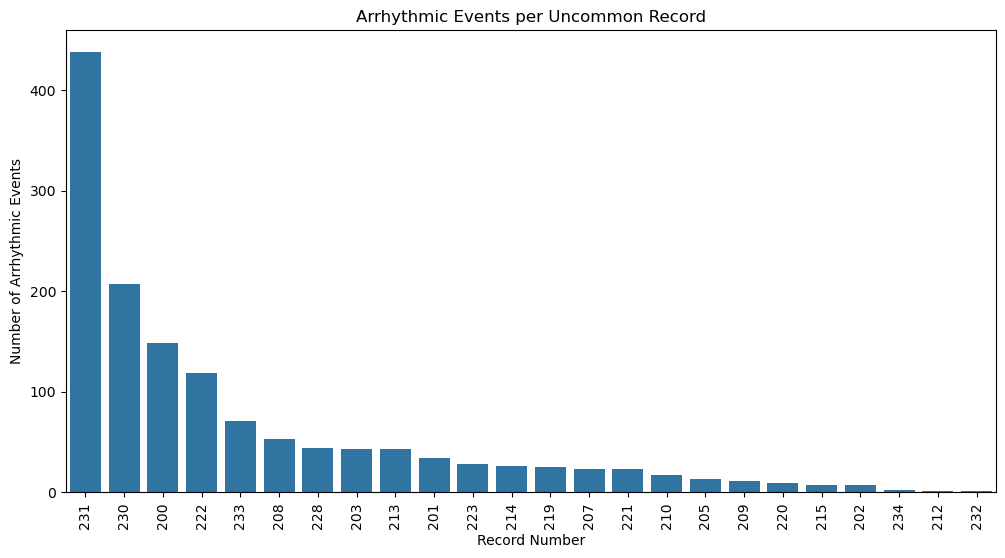

In [991]:
# Plot the number of arrhythmic events per record
plt.figure(figsize=(12, 6))
sns.barplot(x=arrhythmia_counts_un.index, y=arrhythmia_counts_un.values)
plt.title('Arrhythmic Events per Uncommon Record')
plt.xlabel('Record Number')
plt.ylabel('Number of Arrhythmic Events')
plt.xticks(rotation=90)
plt.show()

# Final Remarks
This Exploratory Data Analysisof the MIT-BIH Arrhythmia Database provides insights into ECG Signals, heartbeat types, heart rate variability, and arrhythmias.

By examining both normal and uncommon records, we gain a deeper understanding of the dataset's complexity and the variability present in human heart rhythms.

**Key Takeaways**:
* ECG data is requires careful preprocessing and analysis
* Visualizations are crucial for understanding patterns and anomalies in the data
* Aggregated analysis reveals trends and differences across all the records